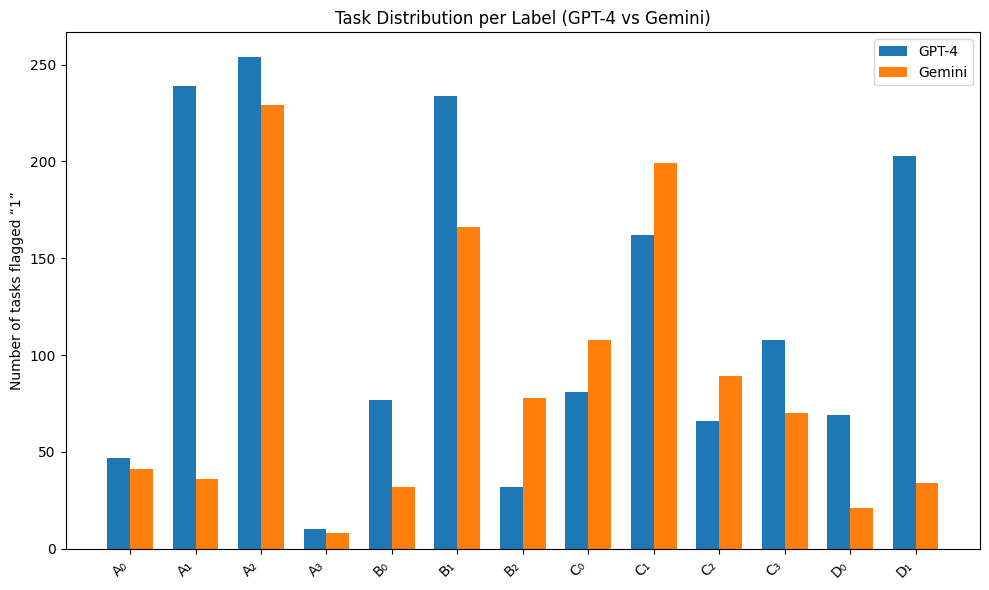

In [7]:
import json
import ast
from pathlib import Path
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1 - CONFIGURATION
# -------------------------------------------------
DATA_FILE = Path("annotation_results_new_sys_prompt.json")  # Path to your JSON file

LABEL_NAMES = [
    "A₀", "A₁", "A₂", "A₃",   # first sublist (len 4)
    "B₀", "B₁", "B₂",         # second sublist (len 3)
    "C₀", "C₁", "C₂", "C₃",   # third sublist (len 4)
    "D₀", "D₁"                # fourth sublist (len 2)
]
N_LABELS = len(LABEL_NAMES)
assert N_LABELS == 13, "Must have exactly 13 label names"

# -------------------------------------------------
# 2 - SMART FLATTENING FUNCTION
# -------------------------------------------------
def to_flat(x):
    """
    Take x, which might be:
      - a JSON-style string '"[[0,1],[1,0]]"'
      - a Python-style literal string "'[[0,1],[1,0]]'"
      - an actual list-of-lists
      - a bare int
    and return a flat list of ints.
    """
    # If it's already a Python object
    if isinstance(x, list):
        nested = x
    elif isinstance(x, str):
        s = x.strip()
        #print('Evaluating ' + s)
        # try JSON
        try:
            nested = json.loads(s)
        except json.JSONDecodeError:
            # fallback to Python literal
            nested = ast.literal_eval(s)
    else:
        # e.g. x is int
        nested = [x]

    # now flatten, treating any non-list as single element
    flat = []
    for item in nested:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)

    # ensure correct length
    if len(flat) < N_LABELS:
        flat = flat + [0] * (N_LABELS - len(flat))
    elif len(flat) > N_LABELS:
        flat = flat[:N_LABELS]

    return list(map(int, flat))

# -------------------------------------------------
# 3 - LOAD & COUNT
# -------------------------------------------------
with DATA_FILE.open() as f:
    data = json.load(f)

gpt_counts    = np.zeros(N_LABELS, dtype=int)
gemini_counts = np.zeros(N_LABELS, dtype=int)

for rec in data.values():
    gpt_vec    = to_flat(rec.get("gpt_output", 0))
    gemini_vec = to_flat(rec.get("gemini_output", 0))
    gpt_counts    += np.array(gpt_vec,    dtype=int)
    gemini_counts += np.array(gemini_vec, dtype=int)

# -------------------------------------------------
# 4 - PLOT
# -------------------------------------------------
x     = np.arange(N_LABELS)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, gpt_counts,    width, label="GPT-4")
ax.bar(x + width/2, gemini_counts, width, label="Gemini")

ax.set_ylabel("Number of tasks flagged “1”")
ax.set_title("Task Distribution per Label (GPT-4 vs Gemini)")
ax.set_xticks(x)
ax.set_xticklabels(LABEL_NAMES, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
# plt.savefig("task_distribution.png", dpi=300)  # uncomment to save
plt.show()


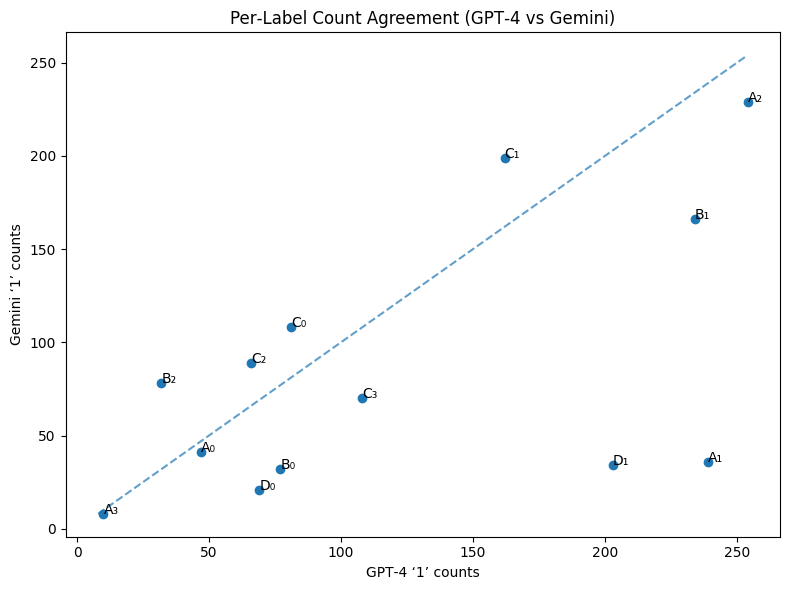

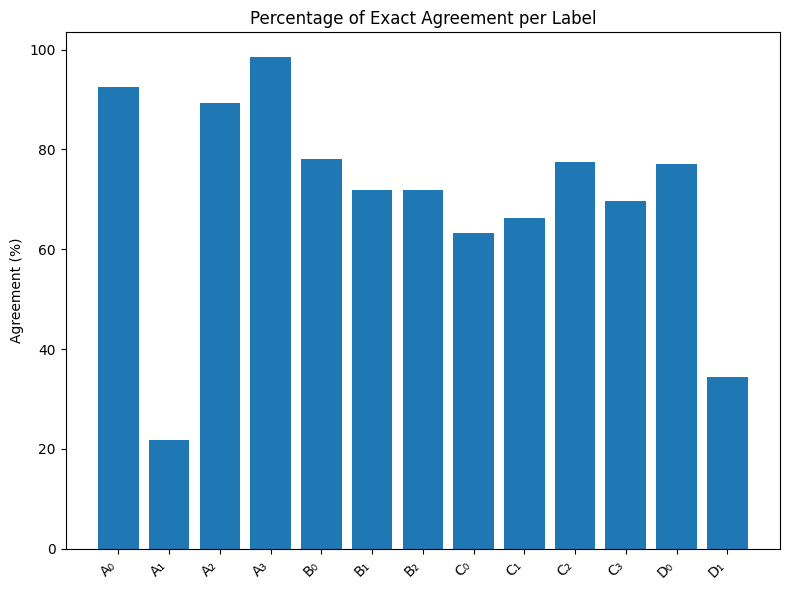

In [8]:
import json
import ast
from pathlib import Path
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1 – CONFIGURATION
# -------------------------------------------------
DATA_FILE = Path("annotation_results_new_sys_prompt.json")  # adjust if your file is elsewhere

LABEL_NAMES = [
    "A₀", "A₁", "A₂", "A₃",  # first sublist (4)
    "B₀", "B₁", "B₂",        # second sublist (3)
    "C₀", "C₁", "C₂", "C₃",  # third sublist (4)
    "D₀", "D₁"               # fourth sublist (2)
]
N_LABELS = len(LABEL_NAMES)

# -------------------------------------------------
# 2 – SMART FLATTENING FUNCTION
# -------------------------------------------------
def to_flat(x):
    """
    Take x (JSON/Python-literal string, list, or int) and return
    a flat list of length N_LABELS, padding/truncating as needed.
    """
    # parse to nested
    if isinstance(x, list):
        nested = x
    elif isinstance(x, str):
        s = x.strip()
        try:
            nested = json.loads(s)
        except json.JSONDecodeError:
            nested = ast.literal_eval(s)
    else:
        nested = [x]

    # flatten
    flat = []
    for item in nested:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)

    # enforce length
    if len(flat) < N_LABELS:
        flat += [0] * (N_LABELS - len(flat))
    else:
        flat = flat[:N_LABELS]

    return list(map(int, flat))

# -------------------------------------------------
# 3 – LOAD & BUILD MATRICES
# -------------------------------------------------
with DATA_FILE.open() as f:
    data = json.load(f)

gpt_matrix    = []
gemini_matrix = []

for rec in data.values():
    gpt_matrix.append(   to_flat(rec.get("gpt_output", 0))    )
    gemini_matrix.append(to_flat(rec.get("gemini_output", 0)) )

gpt_matrix    = np.array(gpt_matrix)
gemini_matrix = np.array(gemini_matrix)

# -------------------------------------------------
# 4 – VISUALIZATION
# -------------------------------------------------

# 4a: Scatter of total “1” counts per label
gpt_counts    = gpt_matrix.sum(axis=0)
gemini_counts = gemini_matrix.sum(axis=0)
x_vals        = np.arange(N_LABELS)
minv, maxv    = np.min([gpt_counts, gemini_counts]), np.max([gpt_counts, gemini_counts])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(gpt_counts, gemini_counts)
ax.plot([minv, maxv], [minv, maxv], linestyle="--", alpha=0.7)
for i, lbl in enumerate(LABEL_NAMES):
    ax.annotate(lbl, (gpt_counts[i], gemini_counts[i]))
ax.set_xlabel("GPT‑4 ‘1’ counts")
ax.set_ylabel("Gemini ‘1’ counts")
ax.set_title("Per‑Label Count Agreement (GPT‑4 vs Gemini)")
plt.tight_layout()
plt.show()

# 4b: Percentage agreement per label
# (both models have the same bit, whether 0 or 1)
agreement_pct = (gpt_matrix == gemini_matrix).sum(axis=0) / gpt_matrix.shape[0] * 100

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x_vals, agreement_pct)
ax.set_xticks(x_vals)
ax.set_xticklabels(LABEL_NAMES, rotation=45, ha="right")
ax.set_ylabel("Agreement (%)")
ax.set_title("Percentage of Exact Agreement per Label")
plt.tight_layout()
plt.show()


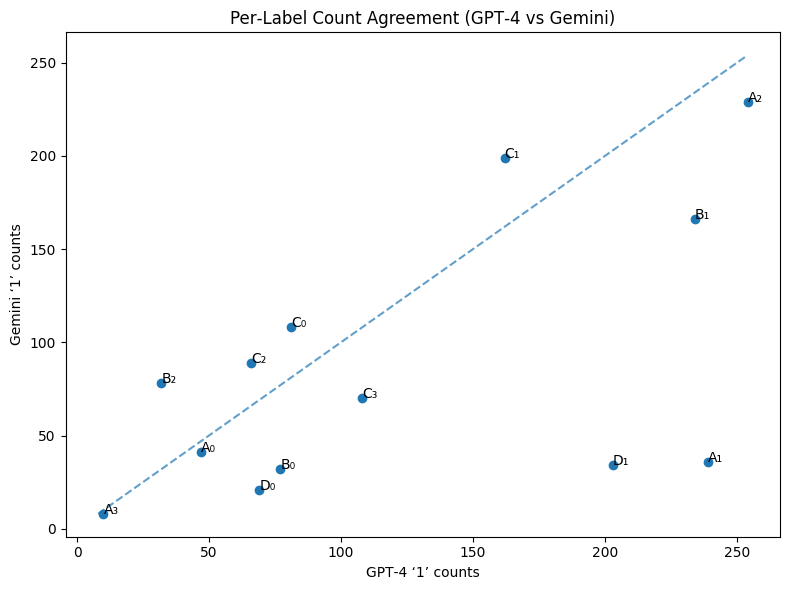

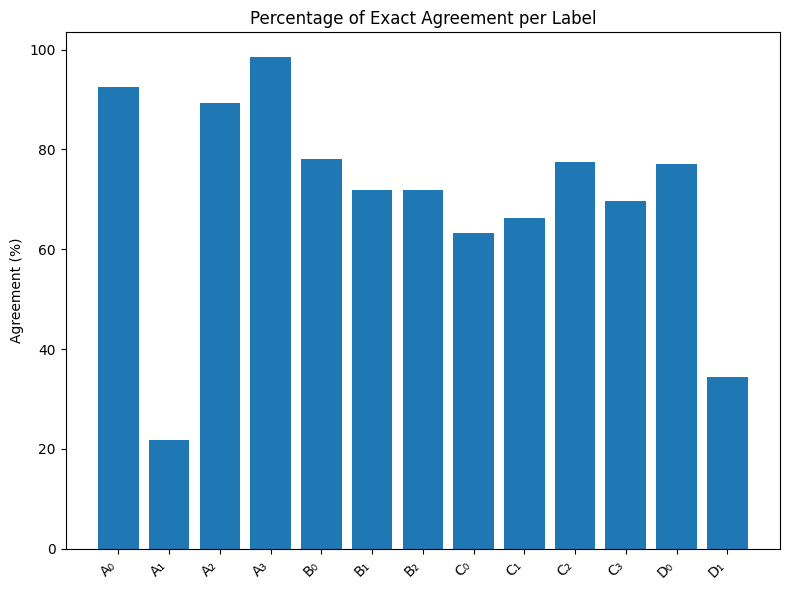


Cohen’s Kappa per Label:

Label  Cohen’s Kappa
   A₀       0.728725
   A₁       0.001262
   A₂       0.443813
   A₃       0.770213
   B₀       0.349849
   B₁       0.323040
   B₂       0.169500
   C₀       0.202899
   C₁       0.255319
   C₂       0.452860
   C₃       0.327869
   D₀       0.217830
   D₁       0.047742


In [9]:
import json
import ast
from pathlib import Path
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# -------------------
# CONFIGURATION
# -------------------
DATA_FILE = Path("annotation_results_new_sys_prompt.json")  # adjust if your file is elsewhere
LABEL_NAMES = [
    "A₀", "A₁", "A₂", "A₃",  # first sublist (4)
    "B₀", "B₁", "B₂",        # second sublist (3)
    "C₀", "C₁", "C₂", "C₃",  # third sublist (4)
    "D₀", "D₁"               # fourth sublist (2)
]
N_LABELS = len(LABEL_NAMES)

# -------------------
# FLATTENING FUNCTION
# -------------------
def to_flat(x):
    if isinstance(x, list):
        nested = x
    elif isinstance(x, str):
        s = x.strip()
        try:
            nested = json.loads(s)
        except json.JSONDecodeError:
            nested = ast.literal_eval(s)
    else:
        nested = [x]

    flat = []
    for item in nested:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)

    # pad or truncate
    if len(flat) < N_LABELS:
        flat += [0] * (N_LABELS - len(flat))
    else:
        flat = flat[:N_LABELS]

    return list(map(int, flat))

# -------------------
# LOAD & BUILD MATRICES
# -------------------
with DATA_FILE.open() as f:
    data = json.load(f)

gpt_matrix    = []
gemini_matrix = []
for rec in data.values():
    gpt_matrix.append(to_flat(rec.get("gpt_output", 0)))
    gemini_matrix.append(to_flat(rec.get("gemini_output", 0)))

gpt_matrix    = np.array(gpt_matrix)
gemini_matrix = np.array(gemini_matrix)

# -------------------
# PLOT AGREEMENT VISUALS
# -------------------
# 1) Scatter of total “1” counts per label
gpt_counts    = gpt_matrix.sum(axis=0)
gemini_counts = gemini_matrix.sum(axis=0)
x_vals        = np.arange(N_LABELS)
minv, maxv    = min(gpt_counts.min(), gemini_counts.min()), max(gpt_counts.max(), gemini_counts.max())

plt.figure(figsize=(8,6))
plt.scatter(gpt_counts, gemini_counts)
plt.plot([minv, maxv], [minv, maxv], '--', alpha=0.7)
for i, lbl in enumerate(LABEL_NAMES):
    plt.text(gpt_counts[i], gemini_counts[i], lbl)
plt.xlabel("GPT‑4 ‘1’ counts")
plt.ylabel("Gemini ‘1’ counts")
plt.title("Per‑Label Count Agreement (GPT‑4 vs Gemini)")
plt.tight_layout()
plt.show()

# 2) Percentage exact agreement per label
agreement_pct = (gpt_matrix == gemini_matrix).sum(axis=0) / gpt_matrix.shape[0] * 100

plt.figure(figsize=(8,6))
plt.bar(x_vals, agreement_pct)
plt.xticks(x_vals, LABEL_NAMES, rotation=45, ha="right")
plt.ylabel("Agreement (%)")
plt.title("Percentage of Exact Agreement per Label")
plt.tight_layout()
plt.show()

# -------------------
# 3) COHEN’S KAPPA TABLE
# -------------------
kappas = [cohen_kappa_score(gpt_matrix[:, i], gemini_matrix[:, i]) 
          for i in range(N_LABELS)]

df_kappa = pd.DataFrame({
    "Label": LABEL_NAMES,
    "Cohen’s Kappa": kappas
})

print("\nCohen’s Kappa per Label:\n")
print(df_kappa.to_string(index=False))
